# packages used

In [2]:
%matplotlib inline

# misc
from IPython.display import display, HTML
import numpy as np

# DATA - prep
#kaggle
import pandas as pd
import sklearn.model_selection

# ML - models 
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import xgboost.sklearn

# ML - accuracy
import sklearn.metrics


# Plot and visualize
import matplotlib.pyplot as plt
import shap

/Users/epedersen/.pyenv/versions/3.7.0/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Get data

Setup:
- follow "API credential step" listed here: https://github.com/Kaggle/kaggle-api
    - go to https://www.kaggle.com/ (login)
    - go to my_profile (download kaggle.json)
    - put it in ~/.kaggle/kaggle.json
    - `cp ~/Downloads/kaggle.json ~/.kaggle/kaggle.json`
    - `chmod 600 ~/.kaggle/kaggle.json`
- Go to kaggle and join competition: 
    - https://www.kaggle.com/c/titanic
- install kaggle
- download data
- profit!!!

In [3]:
!pip install kaggle -q
# -q is just for quite, so we don't spam the notebook

In [4]:

metadata = {
    'basepath' : '../data/',
    'dataset':'titanic',
    'train' : 'train.csv',
    'test' : 'test.csv'}


In [5]:
# make folder
# download .zip
# unzip
# remove the .zip
# (data is placed ../data/titanic)

!mkdir -p {metadata['basepath']}
!kaggle competitions download -c dataset {metadata['dataset']} -p {metadata['basepath']}
!unzip -o {metadata['basepath']}{metadata['dataset']}.zip -d {metadata['basepath']}{metadata['dataset']}/
!rm {metadata['basepath']}{metadata['dataset']}.zip

  0%|                                               | 0.00/34.1k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 17.4MB/s]
Archive:  ../data/titanic.zip
  inflating: ../data/titanic/gender_submission.csv  
  inflating: ../data/titanic/test.csv  
  inflating: ../data/titanic/train.csv  


# Load and explore

In [6]:
# load
train = pd.read_csv("{basepath}/{dataset}/{train}".format(**metadata))
test = pd.read_csv("{basepath}/{dataset}/{test}".format(**metadata))


In [7]:
# Train
display(HTML("<h1>train</h1>"))
# example data
display(train.head(3))
# summary stats
display(train.describe())
# list missing values
display(pd.DataFrame(train.isna().mean() ,columns=["is na fraction"]))
# list types of column
display(train.dtypes)
# list dimenstion
display(train.shape)


# TODO check test

display(HTML("<h1>test</h1>"))
display(pd.DataFrame(test.isna().mean() ,columns=["is na fraction"]))


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,is na fraction
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.198653
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

(891, 12)

,is na fraction
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.205742
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.002392
Cabin,0.782297


# Simple imputation + cleaning

In [8]:
def clean(df):
    dfc = df.copy()
    
    # Simple map
    dfc['Sex'] = dfc['Sex'].map({"female":0,"male":1}).astype(int)
    
    # simple Impute
    dfc['Age'] = dfc["Age"].fillna(-1)
    dfc['Fare'] = dfc["Fare"].fillna(-1)

    # Simple feature engineering (combining two variables)
    dfc['FamilySize'] = dfc['SibSp'] + dfc['Parch'] + 1

    # Simple feature engineering (converting to boolean)
    dfc['Has_Cabin'] = dfc["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    dfc = dfc.drop(["Cabin"],axis=1)
    
    # "Stupid feature engineering - apply length 
    dfc['Name_length'] = dfc['Name'].apply(len)
    dfc = dfc.drop(["Name"],axis=1)
    dfc['Ticket_length'] = dfc['Ticket'].apply(len)
    dfc = dfc.drop(["Ticket"],axis=1)
    
    # 1-hot encoding - different options are encoded as booleans
    # ie. 1 categorical - become 3: 0-1 features.
    dfc['Embarked_Q'] = dfc['Embarked'].apply(lambda x: 1 if x=="Q" else 0)
    dfc['Embarked_S'] = dfc['Embarked'].apply(lambda x: 1 if x=="S" else 0)
    dfc['Embarked_C'] = dfc['Embarked'].apply(lambda x: 1 if x=="C" else 0)
    dfc = dfc.drop(["Embarked"],axis=1)
    
    
    return dfc



clean_train = clean(train)
clean_test = clean(test)


In [9]:
display(pd.DataFrame(clean_test.isna().mean() ,columns=["is na fraction"]))


,is na fraction
PassengerId,0.0
Pclass,0.0
Sex,0.0
Age,0.0
SibSp,0.0
Parch,0.0
Fare,0.0
FamilySize,0.0
Has_Cabin,0.0
Name_length,0.0


In [10]:
# clean data / build feature 
# to_expand

target = "Survived"
# keep numeric features without missing vals
#keep_features = ["Pclass","SibSp","Parch"]

y = clean_train[target]
X = clean_train.drop([target],axis=1)

In [11]:
# Split data in train and validation
target = "Survived"

seed = 42
test_size = 0.7

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X,
    y,
    random_state = seed,
    test_size = test_size)


# ML

In [33]:


# default models
# Logistic regression 
model_logreg = sklearn.linear_model.LogisticRegression()
model_logreg.fit(X_train, y_train);

# decision tree
model_decision_tree = sklearn.tree.DecisionTreeClassifier()
model_decision_tree.fit(X_train, y_train);

# randomForest
model_random_forest = sklearn.ensemble.RandomForestClassifier()
model_random_forest.fit(X_train, y_train);

# xgboost
model_xgboost = xgboost.sklearn.XGBClassifier()
model_xgboost.fit(X_train, y_train);



/Users/epedersen/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/epedersen/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Hyper parameter tuning

## xgboost

In [149]:
##### from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
        'n_estimators' : [100,200,300],
        'max_depth': [2,3,5,8],
        'min_sample_split': [2,3,5,8],
        "learning_rate": [0.05,0.1,0.5]
}


model_xgboost_dummy = xgboost.sklearn.XGBClassifier(min_sample_split=3,learning_rate=0.1)
grid_search_xgb = GridSearchCV(estimator = model_xgboost_dummy, param_grid = xgb_param_grid , 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    9.7s finished
/Users/epedersen/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1,
       min_sample_split=3, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300], 'max_depth': [2, 3, 5, 8], 'min_sample_split': [2, 3, 5, 8], 'learning_rate': [0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [150]:
best_grid = grid_search_xgb.best_params_
display(best_grid)
model_xgboost_best = xgboost.sklearn.XGBClassifier(**best_grid)
model_xgboost_best.fit(X_train,y_train);



{'learning_rate': 0.05,
 'max_depth': 5,
 'min_sample_split': 2,
 'n_estimators': 100}

## logreg

In [147]:

tree_param_grid = {
        'max_depth': [3,7,10,17],
        'min_samples_split': [2,5,7,12,19,31],
}


model_decision_tree_dummy = sklearn.tree.DecisionTreeClassifier()

grid_search_decision_tree = GridSearchCV(estimator = model_decision_tree_dummy, param_grid = tree_param_grid , 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_decision_tree.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/Users/epedersen/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 7, 10, 17], 'min_samples_split': [2, 5, 7, 12, 19, 31]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [140]:
best_grid = grid_search_decision_tree.best_params_
display(best_grid)
model_decision_tree_best = sklearn.tree.DecisionTreeClassifier(**best_grid)
model_decision_tree_best.fit(X_train,y_train);

{'max_depth': 17, 'min_samples_split': 5}

# Eval ML

In [151]:
# naive model
class naive_model():
    # everyone dies
    def predict(self, df):
        return np.zeros(df.shape[0])

model_naive = naive_model()

models = {
    "model_naive" : model_naive,
    "model_logreg" : model_logreg,
    "model_decision_tree": model_decision_tree,
    "model_decision_tree_best":model_decision_tree_best,
    "model_random_forest": model_random_forest,
    "model_xgboost" :model_xgboost,
    "model_xgboost_best" :model_xgboost_best
}

for name,model in zip(models.keys(),models.values()):
    acc = sklearn.metrics.accuracy_score(
     y_true = y_val,
     y_pred = model.predict(X_val)
    )
    acc_train = sklearn.metrics.accuracy_score(
     y_true = y_train,
     y_pred = model.predict(X_train)
    )
    
    print(name," | train: ",round(acc_train,3)," | test: ",round(acc,3))



model_naive  | train:  0.633  | test:  0.609
model_logreg  | train:  0.805  | test:  0.809
model_decision_tree  | train:  1.0  | test:  0.744
model_decision_tree_best  | train:  0.963  | test:  0.75
model_random_forest  | train:  0.985  | test:  0.817
model_xgboost  | train:  0.955  | test:  0.817
model_xgboost_best  | train:  0.959  | test:  0.812


# Visualize feature importance

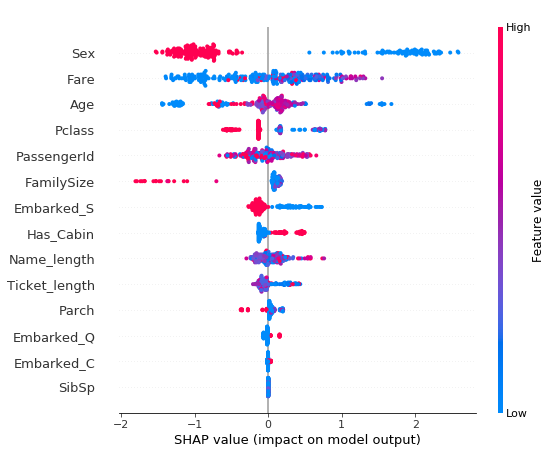

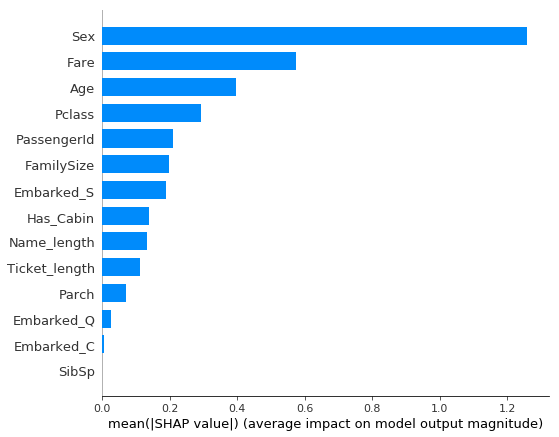

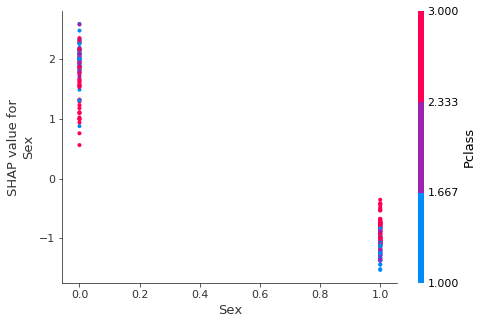

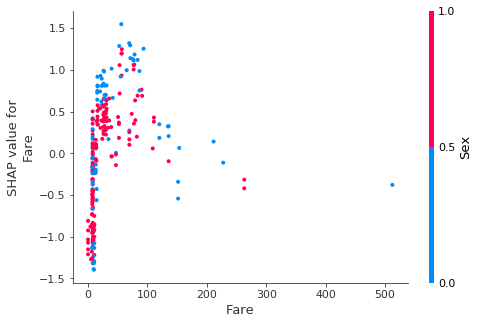

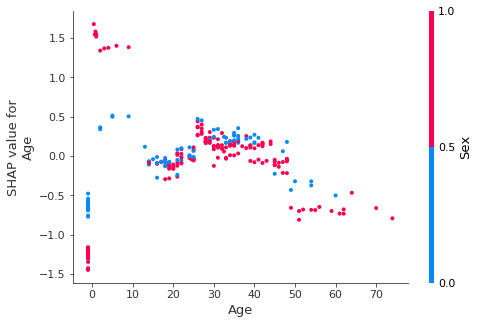

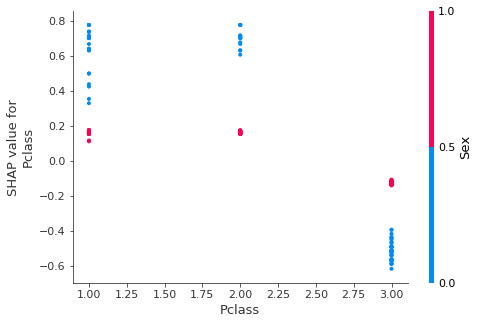

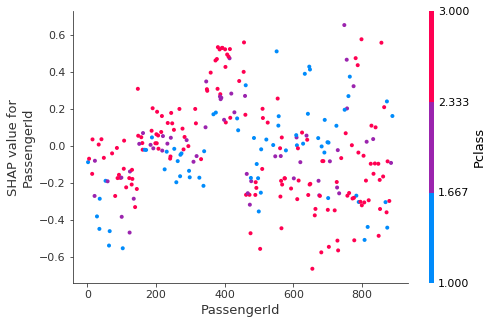

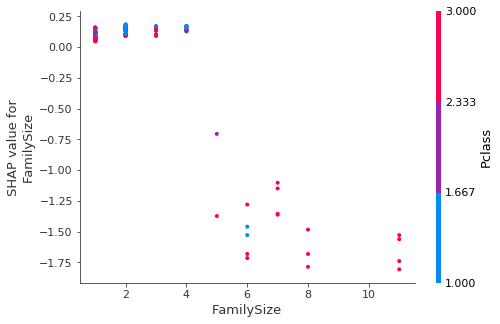

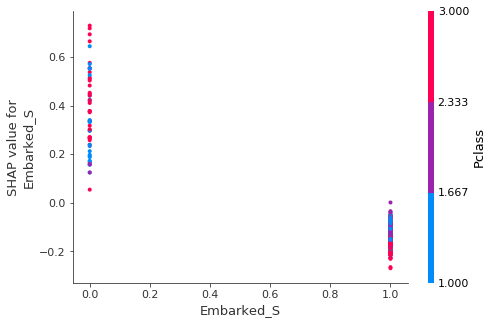

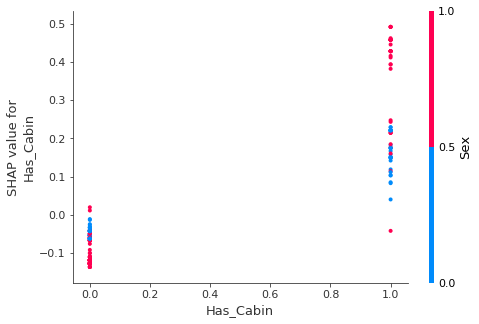

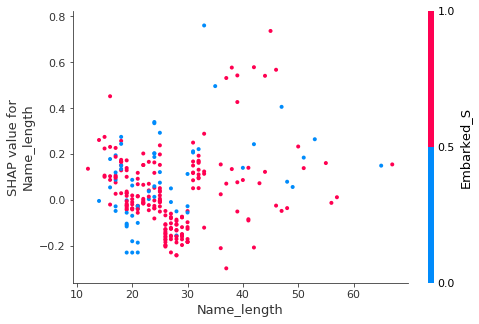

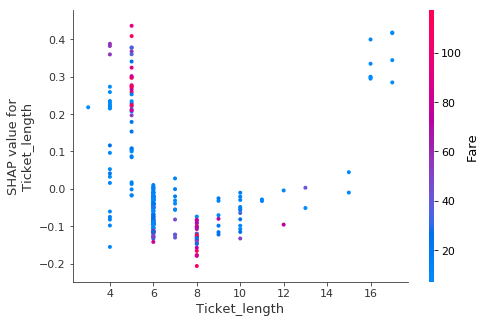

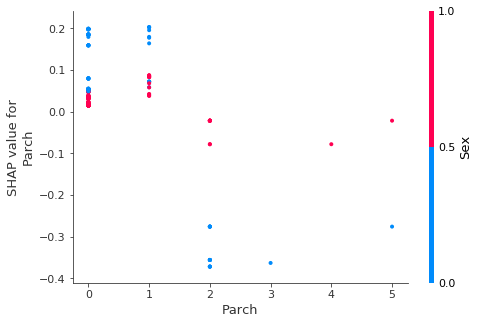

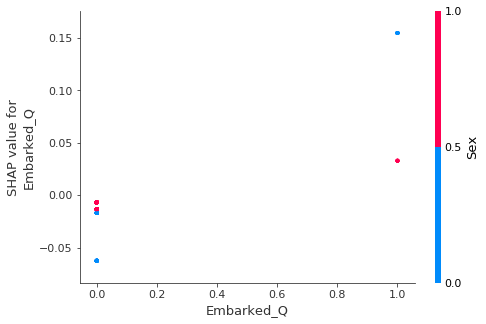

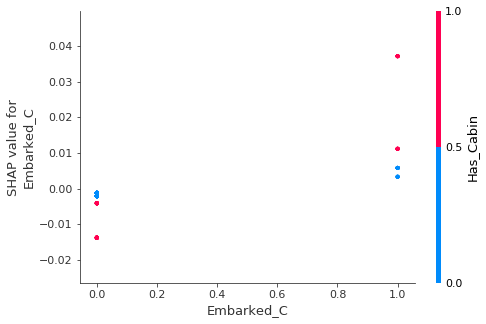

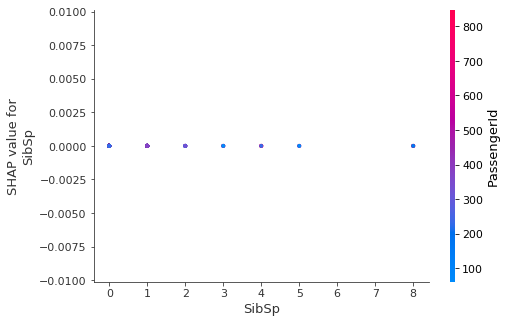

In [15]:

def plot_feature_graphs(model, X, plot_all=True):
    #xgb.plot_importance(model)
    plt.show()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)
    shap.summary_plot(shap_values, X, plot_type='bar')
    if plot_all:
        vals = list(np.abs(shap_values).mean(0))
        labels = list(X.columns.values)
        col_order = [x for _,x in sorted(zip(vals,labels),reverse=True)]
        for c in col_order:
            shap.dependence_plot(c,shap_values,X)
            
plot_feature_graphs(model_xgboost, X_train)

# Output

In [156]:
# passengerid
id = "PassengerId"
out = pd.DataFrame(data = test[id], columns = [id])

# target
out_target = model_xgboost.predict(clean_test)
out[target] = pd.DataFrame(out_target
                          ,columns = [target]
                          ,dtype=np.int32
                          )


# put them out
outfile = metadata["basepath"] + "output_logreg.csv"
out.to_csv(path_or_buf = outfile,
           index = False)



In [157]:
# Submit
#!kaggle competitions submit {metadata['dataset']} -f {outfile} -m "simple xgboost"

100%|████████████████████████████████████████| 2.77k/2.77k [00:04<00:00, 658B/s]
Successfully submitted to Titanic: Machine Learning from Disaster

In [159]:
# See submission 
!kaggle competitions submissions "{metadata['dataset']}"

fileName                     date                 description                                          status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
output_logreg.csv            2020-02-11 23:11:48  minimal model                                        complete  0.76076      None          
output_xgboost_features.csv  2019-12-02 19:37:32  created_features                                     complete  0.74641      None          
output_xgboost_features.csv  2019-12-02 19:35:33  minimal model                                        error     None         None          
output_logreg.csv            2019-12-01 21:51:33  minimal model                                        complete  0.65550      None          
output_logreg.csv            2019-12-01 21:50:01  minimal model                                        complete  0.65550      None          
output_logreg